In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from tensorflow.data import AUTOTUNE
import sentiment


DATASET_DIR = './goemotions/data-v2/'

In [2]:
classes = sentiment.load_classes(DATASET_DIR)
classes

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']

Random seed: 1681944339


D:\sentiment-analysis\sentiment.py:286: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  class_mask = (train_df['labels'].str.contains(r'(^|,)' + label +
D:\sentiment-analysis\sentiment.py:613: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classes, rotation=45, ha='right')


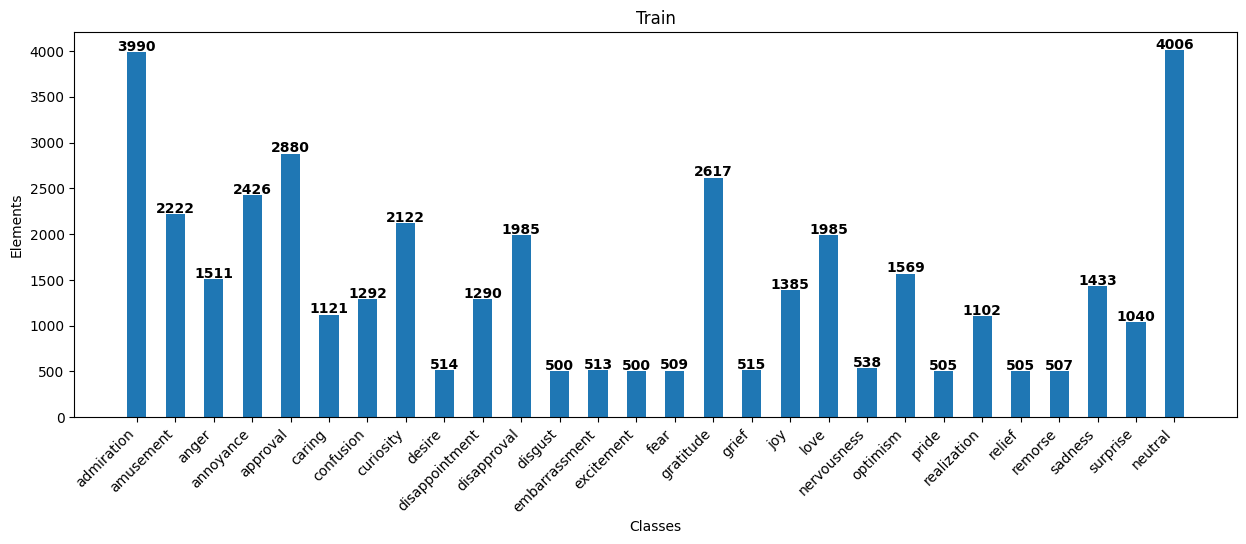

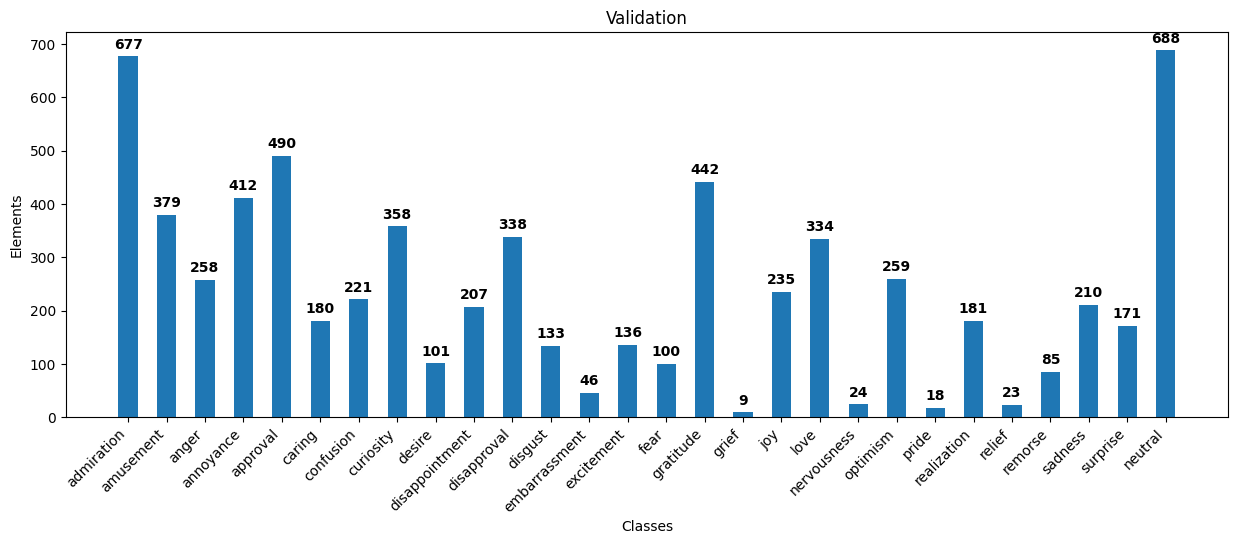

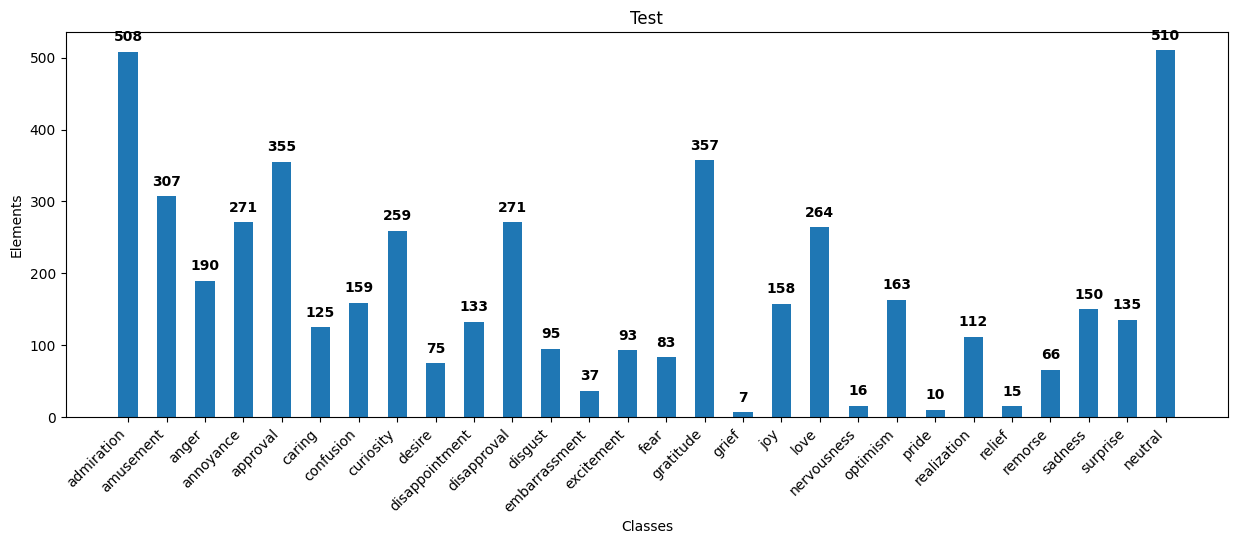

CPU times: total: 9.08 s
Wall time: 9.46 s


In [3]:
%%time
BATCH_SIZE = 32


train_df, val_df, test_df = sentiment.make_dataframes(DATASET_DIR,
                                                      fraction=0.85,
                                                      split_by_class=True,
                                                      clean=True,
                                                      cut_neutral=True,
                                                      test_only_singles=True,
                                                      oversample_low=True,
                                                      low_threshold=500)
dataframes = {'Train': train_df, 'Validation': val_df, 'Test': test_df}
for title, df in dataframes.items():
    sentiment.plot_class_distr(df, classes, title)
train_ds = sentiment.make_ts_ds(train_df, classes, BATCH_SIZE, AUTOTUNE)
val_ds = sentiment.make_ts_ds(val_df, classes, BATCH_SIZE, AUTOTUNE)
test_ds = sentiment.make_ts_ds(test_df, classes, BATCH_SIZE, AUTOTUNE)

In [4]:
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [5]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [6]:
text_test = ['I am feeling sad and lonely today']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 1045 2572 3110 6517 1998 9479 2651  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [7]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [8]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Pooled Outputs Shape:(1, 128)
Pooled Outputs Values:[-0.99999136  0.08191041 -0.9997363   0.9891061  -0.9994392   0.6426271
 -0.99642986 -0.04943833  0.08171504  0.04948686 -0.7958412  -0.04962895]
Sequence Outputs Shape:(1, 128, 128)
Sequence Outputs Values:[[-1.1542702  -0.44949532 -3.3050992  ... -0.27842605 -0.4901824
   0.78527725]
 [-0.8928114  -0.68425363 -0.13896418 ... -1.6181747  -1.3698293
   0.50157887]
 [-0.9860739  -0.31338978 -1.2287494  ... -0.502259   -1.7966256
   0.5462902 ]
 ...
 [-1.6846545  -0.00387354 -0.12156503 ... -1.3318069  -0.74090356
   1.5787063 ]
 [-1.350074   -0.18482555 -0.18486801 ... -1.5990545  -0.8795686
   1.7834572 ]
 [-0.7529241  -0.72506434 -0.4427926  ... -1.5915537  -0.76583195
   1.740164  ]]


In [9]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(len(classes), activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [10]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor(
[[0.6081679  0.5720786  0.6410917  0.6172822  0.53873247 0.6241657
  0.5614701  0.5858536  0.6257367  0.6120097  0.5767763  0.6068279
  0.60433793 0.6187438  0.59651357 0.6778176  0.60356486 0.65109205
  0.60148066 0.62424374 0.6100177  0.6202327  0.6685699  0.65134686
  0.5929027  0.66852117 0.62171906 0.63717234]], shape=(1, 28), dtype=float32)


In [11]:
classifier = build_classifier_model()

In [12]:
from tensorflow.keras.losses import BinaryCrossentropy
from keras.optimizers import Adam

METRICS_THRESHOLD = 0.5

from official.nlp import optimization  # to create AdamW optimizer
from tensorflow.keras.callbacks import EarlyStopping

epochs = 20
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 1e-3
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
metrics = sentiment.create_metrics(classes, METRICS_THRESHOLD)
loss = BinaryCrossentropy()
classifier.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [13]:
hist = classifier.fit(x=train_ds, validation_data=val_ds, epochs=epochs,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

Epoch 1/20
1009/1009 [==============================] - 635s 620ms/step - loss: 0.2178 - precision@0.5/admiration: 0.3565 - recall@0.5/admiration: 0.2556 - precision@0.5/amusement: 0.2424 - recall@0.5/amusement: 0.2466 - precision@0.5/anger: 0.0863 - recall@0.5/anger: 0.0179 - precision@0.5/annoyance: 0.0716 - recall@0.5/annoyance: 0.0297 - precision@0.5/approval: 0.1055 - recall@0.5/approval: 0.0389 - precision@0.5/caring: 0.0388 - recall@0.5/caring: 0.0250 - precision@0.5/confusion: 0.0734 - recall@0.5/confusion: 0.0201 - precision@0.5/curiosity: 0.1868 - recall@0.5/curiosity: 0.1885 - precision@0.5/desire: 0.0000e+00 - recall@0.5/desire: 0.0000e+00 - precision@0.5/disappointment: 0.0476 - recall@0.5/disappointment: 0.0078 - precision@0.5/disapproval: 0.0632 - recall@0.5/disapproval: 0.0514 - precision@0.5/disgust: 0.0061 - recall@0.5/disgust: 0.0020 - precision@0.5/embarrassment: 0.0175 - recall@0.5/embarrassment: 0.0390 - precision@0.5/excitement: 0.0176 - recall@0.5/excitement: 0.

In [14]:
eval_metrics = classifier.evaluate(x=test_ds, return_dict=True)
sentiment.print_metrics(eval_metrics)

154/154 [==============================] - 24s 153ms/step - loss: 0.1013 - precision@0.5/admiration: 0.5993 - recall@0.5/admiration: 0.7244 - precision@0.5/amusement: 0.7370 - recall@0.5/amusement: 0.8306 - precision@0.5/anger: 0.6143 - recall@0.5/anger: 0.4526 - precision@0.5/annoyance: 0.2981 - recall@0.5/annoyance: 0.2288 - precision@0.5/approval: 0.4444 - recall@0.5/approval: 0.2479 - precision@0.5/caring: 0.4872 - recall@0.5/caring: 0.3040 - precision@0.5/confusion: 0.5577 - recall@0.5/confusion: 0.1824 - precision@0.5/curiosity: 0.4388 - recall@0.5/curiosity: 0.7336 - precision@0.5/desire: 0.5593 - recall@0.5/desire: 0.4400 - precision@0.5/disappointment: 0.1719 - recall@0.5/disappointment: 0.0827 - precision@0.5/disapproval: 0.4414 - recall@0.5/disapproval: 0.2362 - precision@0.5/disgust: 0.8235 - recall@0.5/disgust: 0.2947 - precision@0.5/embarrassment: 0.4762 - recall@0.5/embarrassment: 0.5405 - precision@0.5/excitement: 0.5000 - recall@0.5/excitement: 0.0968 - precision@0.5/f

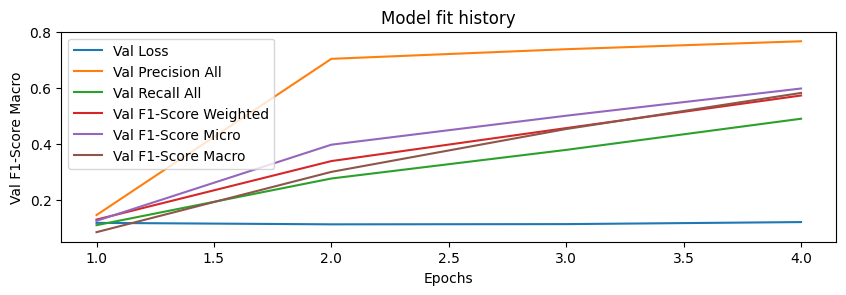

In [15]:
stats = hist.history
stats_graps = {
    'Val Loss': stats['val_loss'],
    'Val Precision All': stats['precision@0.5/all'],
    'Val Recall All': stats['recall@0.5/all'],
    'Val F1-Score Weighted': stats['f1_score@0.5/all'],
    'Val F1-Score Micro': stats['f1_score_micro@0.5/all'],
    'Val F1-Score Macro': stats['f1_score_macro@0.5/all'],
}
sentiment.plot_history(stats_graps)

In [16]:
sentiment.calc_TP_perc(test_ds, classifier)

0.48578391551584077

In [17]:
sentiments = sentiment.load_sentiments(DATASET_DIR)
sentiment_map = sentiment.map_sentiments(classes, sentiments)
sentiment.calc_TP_perc(test_ds, classifier, sentiment_map)

0.6159626320064988

In [18]:
sentiment.test_examples(classifier, classes)

I am feeling great today!: admiration 👏
The weather is so good: admiration 👏
I have performed well at the university: approval 👍
The war has started: neutral ⚪
He is desperate in this cruel world: anger 😡 annoyance 😒
I love the feeling when my girlfriend hugs me: love ❤️
I hate monday mornings: anger 😡
WARNING! Model not sure (all predictions less than 0.5)
Look forward to seeing you today: approval 👍
Merry Christmas! I told Santa you were good this year and asked him to bring you a year full of joy and pleasure : joy 😃
brilliant! Such a detailed review, it was a pleasure, thank you! Guys, make sure you find time to read :) Aaaaand you can actually choose sth new): gratitude 🙏
I have the new pan for pancakes.: admiration 👏
I'm wearing a special red ribbon for luck.: optimism 🤞
OMG, yep!!! That is the final answer! Thank you so much!: gratitude 🙏
I am so glad this is over: joy 😃
Sorry, I feel bad for having said that: remorse 😔 sadness 😞
Happy birthday, my friend! I wish you a lot of su

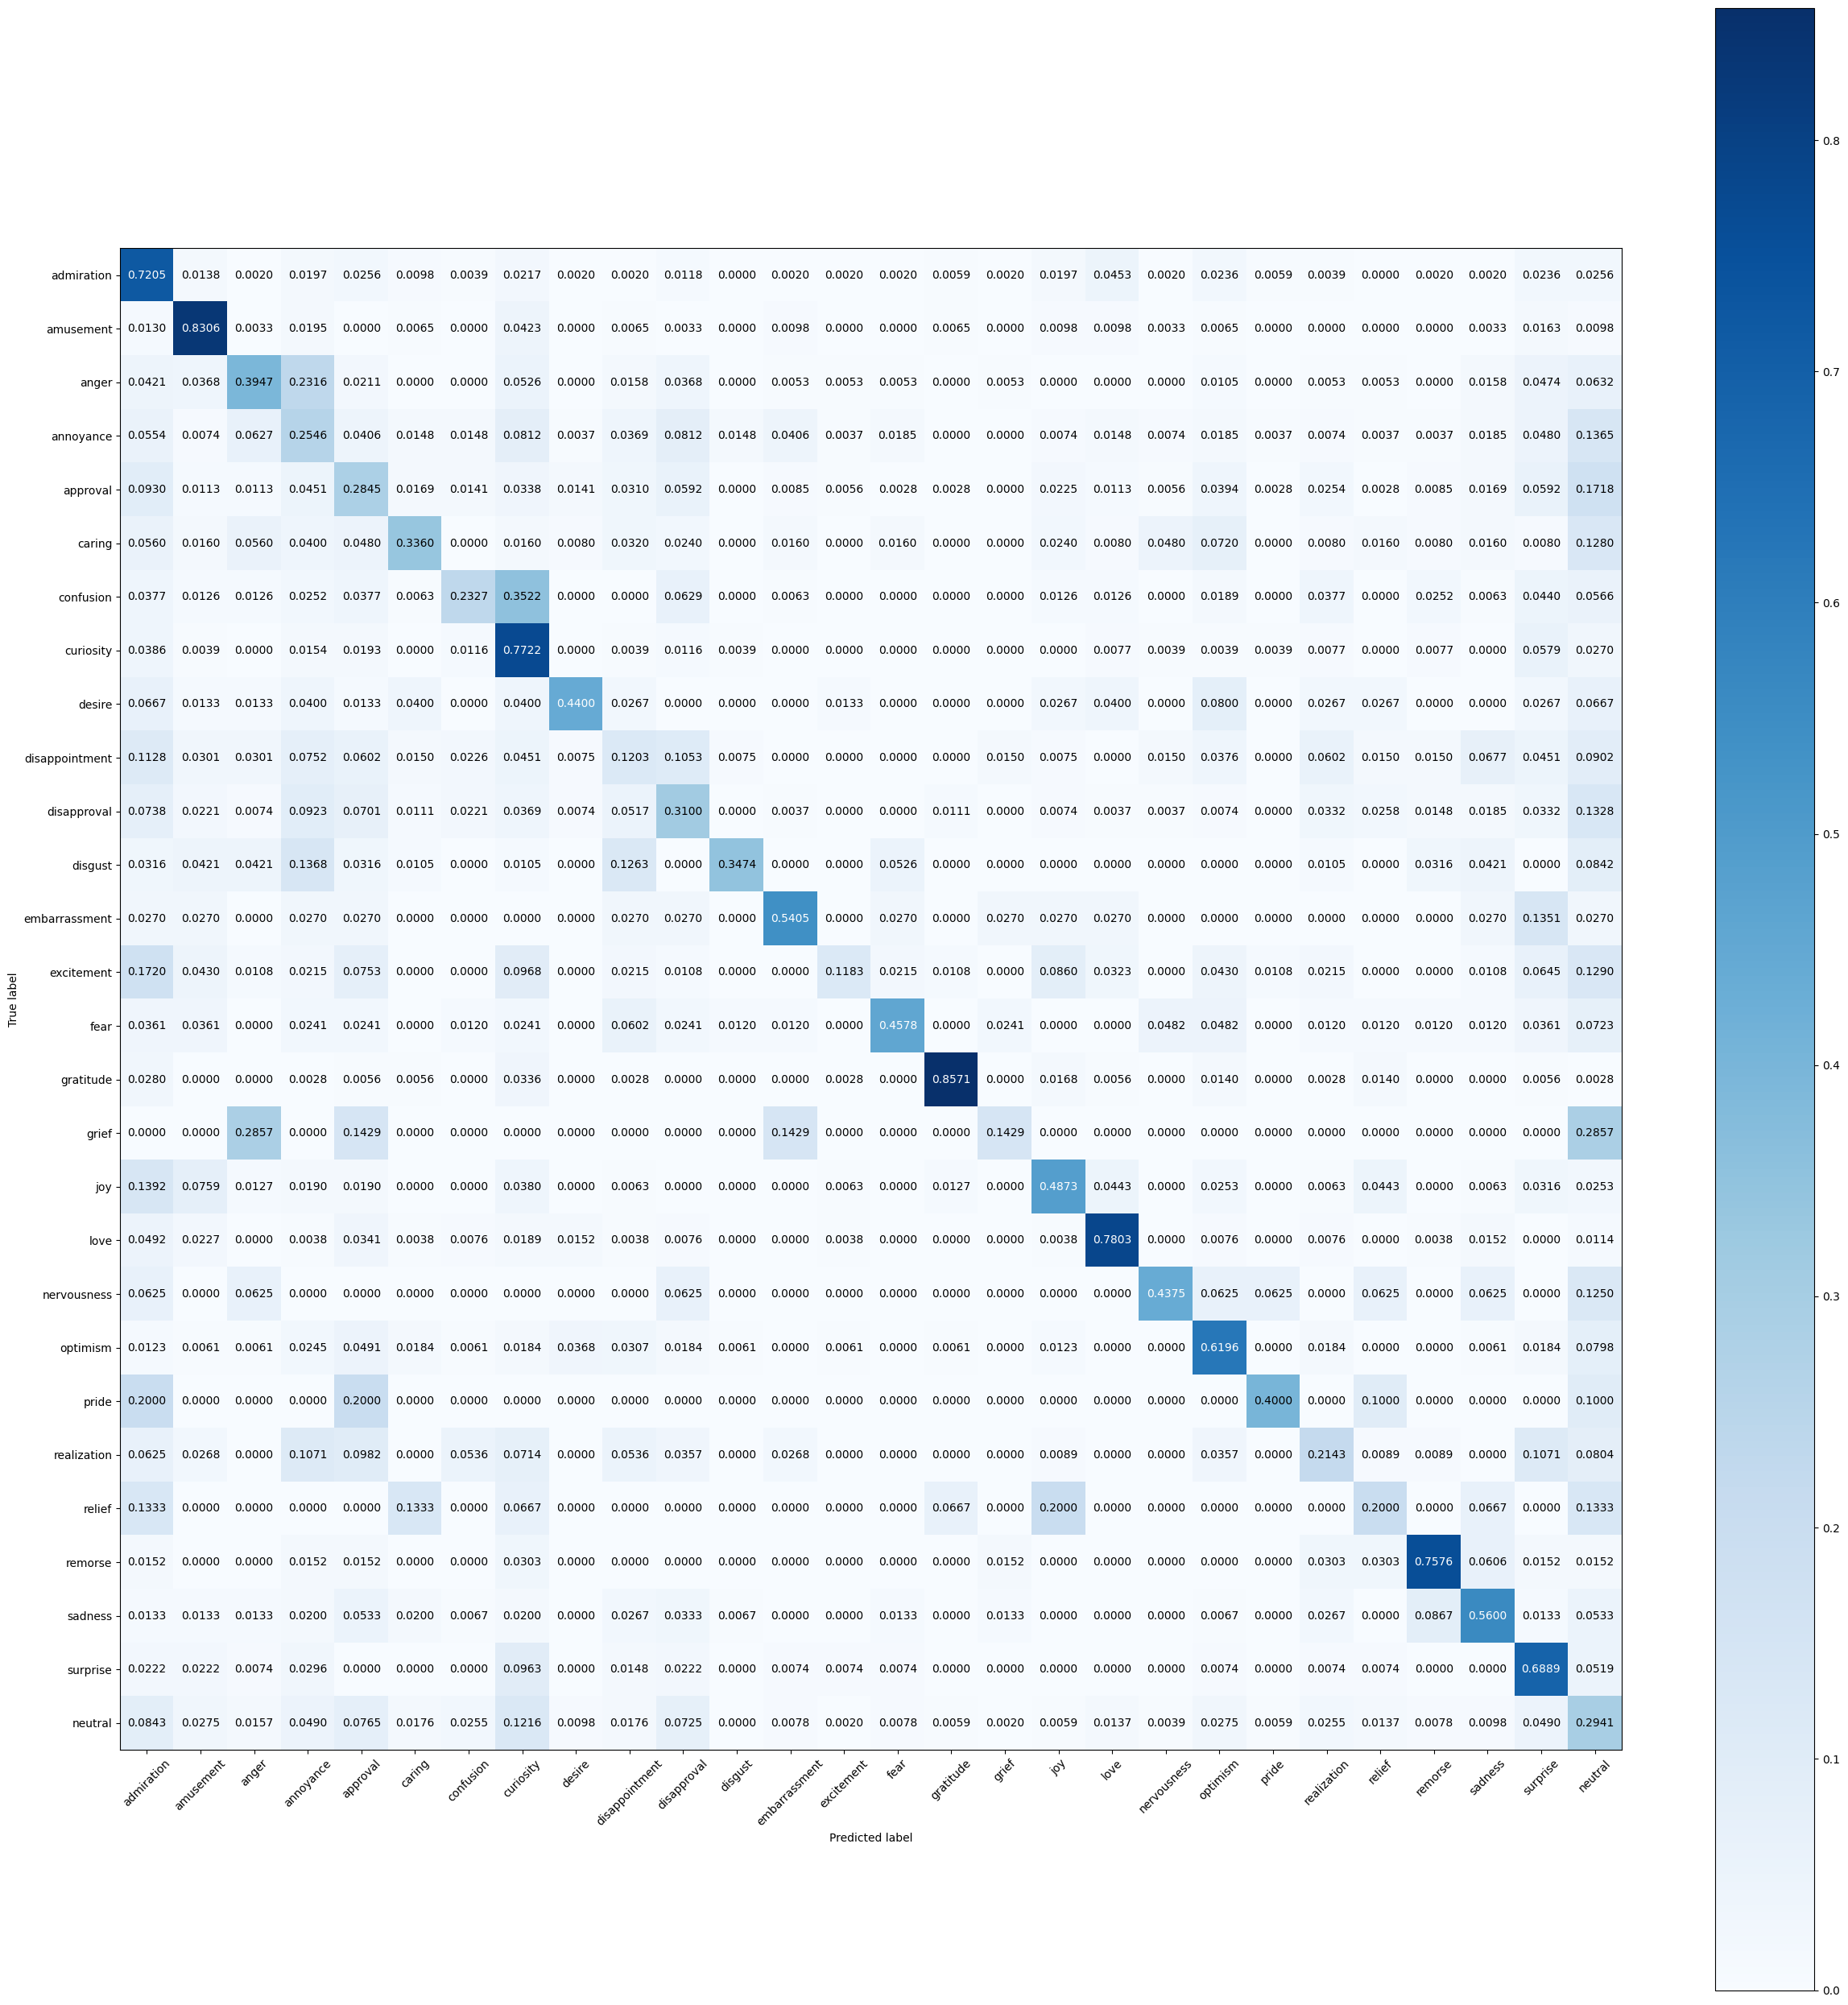

In [19]:
sentiment.plot_conf_mtrx_all(classifier, test_ds, classes)

1/1 [==============================] - 1s 530ms/step


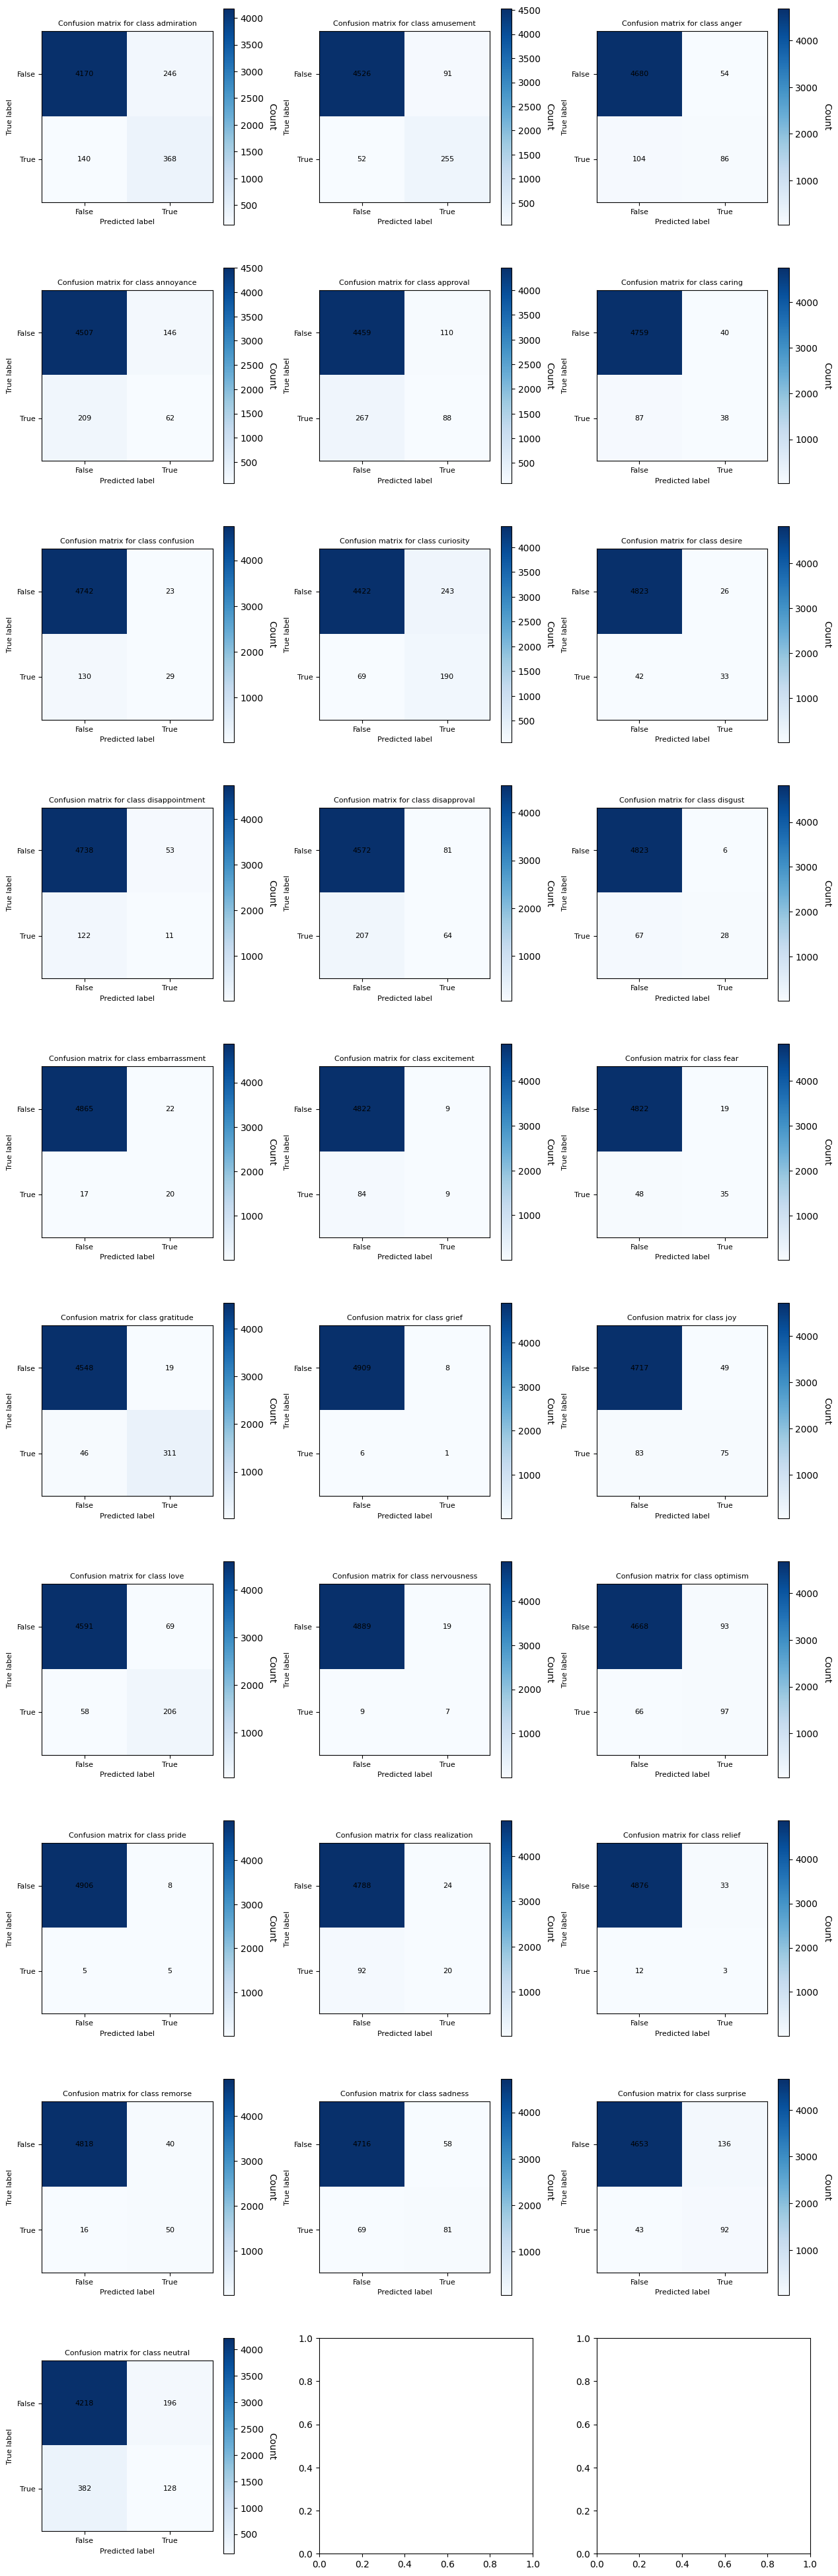

In [20]:
sentiment.plot_conf_mtrx_per_class(classifier, test_ds, classes)

In [21]:
classifier.save('./models/bert', include_optimizer=False)

INFO:tensorflow:Assets written to: ./models/bert\assets


INFO:tensorflow:Assets written to: ./models/bert\assets
